In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
import random
from mpl_toolkits.mplot3d import Axes3D

In [3]:
sns.set_context("paper",font_scale=1.5, rc={"lines.linewidth":2})
sns.set_theme(style="ticks", color_codes=True)
sns.set_style("white")

### CD 24 vs Cell Cycle

In [4]:
# Read cells with Phase
cell_with_phase = pd.read_csv('220416_scTRIP_txn_cell_phase.csv')
# Read cells with CD
cell_with_cd = pd.read_csv('220419_stemness_cluster.csv')

In [5]:
# Process the input
cell_with_phase.rename(columns={'Unnamed: 0':'cellBC'}, inplace=True)
cell_with_cd.rename(columns={'Unnamed: 0':'cellBC'}, inplace=True)

In [7]:
cell_with_cd[['cellBC', 'rep']] = cell_with_cd['cellBC'].str.split('-', 1, expand=True)
cell_with_phase[['cellBC', 'rep']] = cell_with_phase['cellBC'].str.split('-', 1, expand=True)

In [8]:
# Count the number of cells with CD in phase
substates = cell_with_cd.manual.unique()
pop_list = []
rep_list = ['1-0', '1-1']
for rep in rep_list:
    cell_with_cd_rep = cell_with_cd[cell_with_cd['rep'] == rep]
    cell_with_phase_rep = cell_with_phase[cell_with_phase['rep'] == rep]
    for substate in substates:
        cell_bcs = cell_with_cd_rep.loc[cell_with_cd_rep.manual == substate, 'cellBC']
        # Count the phases in each dot
        substate_slice = cell_with_phase_rep.loc[cell_with_phase_rep.cellBC.isin(cell_bcs)]
        phases = substate_slice.phase.unique()
        for phase in phases:
            fraction = len(substate_slice.loc[substate_slice.phase == phase])/len(substate_slice)
            pop_list.append([substate, phase, fraction, rep])
pop_df = pd.DataFrame(pop_list, columns=['substate', 'phase', 'fraction', 'rep'])

In [9]:
from statannotations.Annotator import Annotator

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD24_G2M vs. Diff_G2M: t-test independent samples, P_val:6.164e-02 t=-3.839e+00
CD24_S vs. Diff_S: t-test independent samples, P_val:3.087e-02 t=5.559e+00
CD24_G1 vs. Diff_G1: t-test independent samples, P_val:5.062e-01 t=8.031e-01


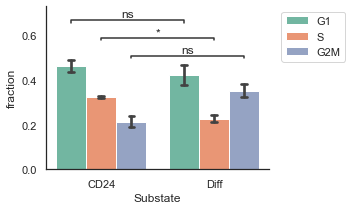

In [10]:
pairs = [(('CD24', 'S'), ('Diff', 'S')), (('CD24', 'G1'), ('Diff', 'G1')),(('CD24', 'G2M'), ('Diff', 'G2M'))]
order = ['CD24','Diff']
hue_order = ['G1', 'S', 'G2M']
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.barplot(x = 'substate', y = 'fraction', hue = 'phase', order = order, capsize = .05, hue_order = hue_order,palette= 'Set2', data = pop_df)
annot = Annotator(ax, pairs, data=pop_df, x='substate', hue= 'phase', hue_order = hue_order,  order = order, y='fraction')
annot.configure(test='t-test_ind', text_format = 'star', verbose=2)
annot.apply_test()
annot.annotate()
sns.despine()
ax.set_xlabel('Substate')
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
#plt.savefig('220522_stem_cell_cycle.pdf', dpi=300, bbox_inches='tight')

In [85]:
pop_df.pivot(index='substate', columns='phase', values='fraction')

phase,G1,G2M,S
substate,,,
CD24,0.463316,0.213708,0.322977
Diff,0.428023,0.347848,0.224129


## Infograph for source of extrinsic noise

In [76]:
# Now we make an infograph for overall mean and MIN based on different mixture
def generate_sampling():
    sim_num = 1000
    dist_1 = np.random.negative_binomial(2, 0.1, sim_num)
    dist_2 = np.random.negative_binomial(1, 0.1, sim_num)
    dist_3 = np.random.negative_binomial(1, 0.1, sim_num)
    # Proportion list
    prop_list = np.arange(0,0.5, 0.01)
    # Initialize the dataframe
    pop_list = []
    for prop1 in prop_list:
        for prop2 in prop_list:
            prop1 = round(prop1,2)
            prop2 = round(prop2,2)
            prop3 = 1- prop1 - prop2
            total_dist = random.sample(list(dist_1), round(sim_num*prop1)) + random.sample(list(dist_2), round(sim_num*prop2)) + random.sample(list(dist_3), round(sim_num*prop3))
            pop_list.append([prop1, prop2, np.mean(total_dist), np.var(total_dist)/(np.mean(total_dist)**2)] )
    pop_df = pd.DataFrame(pop_list, columns=['prop_1', 'prop_2', 'mean', 'MIN'])
    return pop_df

In [77]:
pop_df = generate_sampling()

In [100]:
x = [np.mean(a) for a in not_source_list]
y = [(np.var(a)/(np.mean(a)**2)) for a in not_source_list]
label = ['S', 'G1', 'G2/M', 'Total']

In [112]:
pop_df[(pop_df['prop_1'] == 0.33)&(pop_df['prop_2'] == 0.33)]

,prop_1,prop_2,mean,MIN
1683,0.33,0.33,12.186,0.902173


In [120]:
pop_df[(pop_df['prop_1'] == 0.49)&(pop_df['prop_2'] == 0.1)]

,prop_1,prop_2,mean,MIN
2460,0.49,0.1,13.351,0.826202


KeyError: 'prop_1'

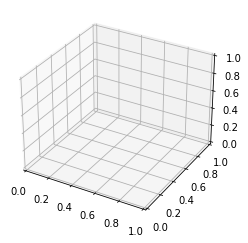

In [11]:
fig = plt.figure(figsize = (4,4))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(pop_df['prop_1'], pop_df['prop_2'], pop_df['mean'],cmap=plt.cm.viridis, linewidth=0.2, alpha = 0.5)
ax.view_init(10, 45)
ax.plot(0.33, 0.33, 12.186, 'o', color='red', markersize=10)
ax.plot(0.49, 0.1, 13.351, 'x', color='green', markersize=10)
ax.set_xlabel('proportion in high distribution')
ax.set_ylabel('proportion in low distribution')
ax.set_zlabel('mean')
ax.set_zlim(6,14)
#plt.savefig('220420_mean_global_factor_info.pdf', dpi=300, bbox_inches='tight')
plt.show()

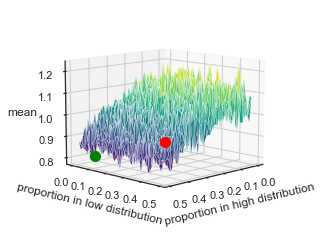

In [155]:
fig = plt.figure(figsize = (4,4))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(pop_df['prop_1'], pop_df['prop_2'], pop_df['MIN'],cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(10, 45)
ax.plot(0.33, 0.33, 0.902, 'o', color='red', markersize=10)
ax.plot(0.49, 0.1, 0.826, 'o', color='green', markersize=10)
ax.set_xlabel('proportion in high distribution')
ax.set_ylabel('proportion in low distribution')
ax.set_zlabel('mean')
#plt.savefig('220420_MIN_global_factor_info.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [94]:
sim_num = 1000
s = np.random.negative_binomial(2, 0.1, round(sim_num/3))
g2 = np.random.negative_binomial(1, 0.1, round(sim_num/3))
g1 = np.random.negative_binomial(1, 0.1, round(sim_num/3))

In [95]:
np.var(g2)/np.mean(g2)**2

1.3052210531935322

In [96]:
not_source_total = random.sample(list(s), 33) + random.sample(list(g1), 33) + random.sample(list(g2),33)

/Users/siqizhao/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/siqizhao/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/siqizhao/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

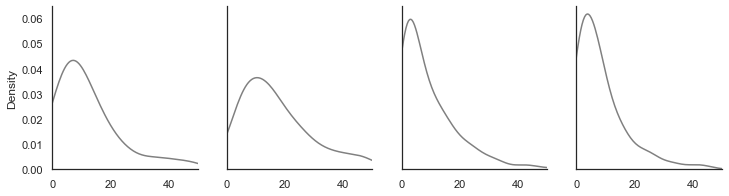

In [156]:
fig, axes = plt.subplots(1, 4, figsize=(12,3), sharey=True)
sns.distplot(ax = axes[0], x=not_source_total ,kde=True, hist=False, label= 'S', color = 'grey')
axes[3].set_xlim(0,50)
sns.distplot(ax = axes[1], x=s,kde=True, hist=False, label= 'S', color = 'grey')
axes[0].set_xlim(0,50)
sns.distplot(ax = axes[2], x=g1,kde=True, hist=False, label= 'G1', color = 'grey')
axes[1].set_xlim(0,50)
sns.distplot(ax = axes[3],x= g2,kde=True, hist=False, label= 'G2/M', color = 'grey')
axes[2].set_xlim(0,50)
sns.despine()
#plt.savefig('220420_cell_cycle.pdf', dpi = 300)

/Users/siqizhao/miniconda3/envs/scwork/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/siqizhao/miniconda3/envs/scwork/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/siqizhao/miniconda3/envs/scwork/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

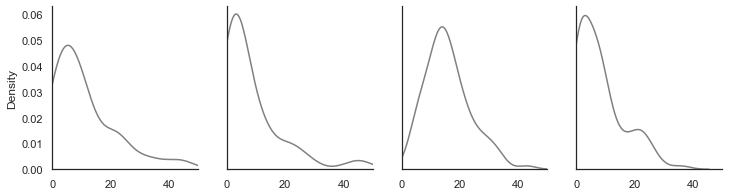

In [263]:
fig, axes = plt.subplots(1, 4, figsize=(12,3), sharey=True)
sns.distplot(ax = axes[0], x= source_total ,kde=True, hist=False, label= 'S', color = 'grey')
axes[3].set_xlim(0,50)
sns.distplot(ax = axes[1], x=g1_d,kde=True, hist=False, label= 'S', color = 'grey')
axes[0].set_xlim(0,50)
sns.distplot(ax = axes[2], x=s_d,kde=True, hist=False, label= 'G1', color = 'grey')
axes[1].set_xlim(0,50)
sns.distplot(ax = axes[3],x= g2_d,kde=True, hist=False, label= 'G2/M', color = 'grey')
axes[2].set_xlim(0,50)
sns.despine()
#plt.savefig('220419_cell_cycle_source.pdf', dpi = 300)

/Users/siqizhao/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


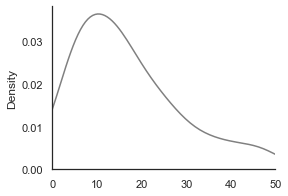

In [159]:
fig, axes = plt.subplots(figsize=(4,3), sharey=True)
sns.distplot(ax = axes, x=s,kde=True, hist=False, label= 'S', color = 'grey')
axes.set_xlim(0,50)
sns.despine()
plt.savefig('220419_cell_cycle_high_distribution.pdf', dpi = 300)

/Users/siqizhao/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


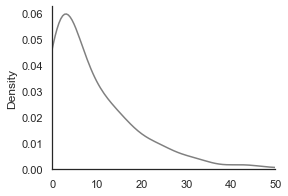

In [160]:
fig, axes = plt.subplots(figsize=(4,3), sharey=True)
sns.distplot(ax = axes, x=g1,kde=True, hist=False, label= 'S', color = 'grey')
axes.set_xlim(0,50)
sns.despine()
#plt.savefig('220419_cell_cycle_low_distribution.pdf', dpi = 300)

In [86]:
not_source_list = [s, g1, g2, not_source_total]

In [88]:
x

[18.234234234234233, 10.237237237237236, 8.84084084084084, 11.080808080808081]

In [250]:
source_list = [s_d, g1_d, g2_d, source_total]
x_d = [np.mean(a) for a in source_list]
y_d = [np.var(a) for a in source_list]

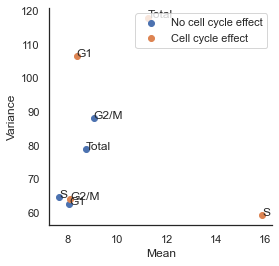

In [254]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x = x, y = y, label = 'No cell cycle effect')
for i, txt in enumerate(label):
    ax.annotate(txt, (x[i], y[i]))
ax.scatter(x = x_d, y = y_d, label = 'Cell cycle effect')
for i, txt in enumerate(label):
    ax.annotate(txt, (x_d[i], y_d[i]))
ax.set_xlabel('Mean')
ax.set_ylabel('Variance')
ax.legend(loc = 'upper right')
sns.despine()
#plt.savefig('220419_cell_cycle_inform_graph_mean_var.pdf', dpi = 300)

In [103]:
np.var([s_d,g1_d,g2_d])

93.48323333333333

In [112]:
np.mean(not_source_total)

26.2

In [105]:
np.mean(s_d)

13.56

In [17]:
trip_phase = pd.read_csv('220419_trip_phase.csv')
trip_stem = pd.read_csv('220419_trip_stem.csv')

In [18]:
pop_df = pd.merge(trip_phase, trip_stem, on = 'tBC', how = 'inner')

In [19]:
pop_df.drop(['Unnamed: 0_x','total_cells_x', 'Unnamed: 0_y', 'total_cells_y'], axis = 1, inplace = True)

In [21]:
pop_df.to_csv('220419_tBC_extrinsic_factors.csv')